In [ ]:
# Análise de Filmes IMDB: Do Dado ao Modelo de Predição

Olá! Bem-vindo a esta análise do dataset de filmes do IMDB. Nosso objetivo é explorar esses dados para entender o que faz um filme ter sucesso e, no final, construir um modelo de "inteligência artificial" capaz de prever a nota de um filme.

Vamos imaginar que somos cientistas de dados ajudando um estúdio de Hollywood!

### Passo 1: Arrumando a Casa (Limpeza dos Dados)

Antes de qualquer análise, precisamos garantir que nossos dados estão "limpos". Isso significa que não há valores faltando, os tipos de dados estão corretos (números são números, texto é texto) e tudo está formatado direitinho.

**Por que isso é importante?** Imagine tentar fazer uma conta de somar com uma palavra. Não dá, né? O computador precisa que os dados estejam no formato certo para trabalhar com eles.

In [1]:
# Primeiro, vamos importar as ferramentas que vamos usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import pickle

# Carregando nossos dados
# Certifique-se de que o arquivo 'desafio_indicium_imdb.csv' está na mesma pasta
df = pd.read_csv('desafio_indicium_imdb.csv')

# Vamos dar uma espiadinha nos dados
print("Cabeçalho dos dados:")
print(df.head())

print("\nInformações sobre as colunas:")
df.info()

Cabeçalho dos dados:
   Unnamed: 0                                   Series_Title Released_Year  \
0           1                                  The Godfather          1972   
1           2                                The Dark Knight          2008   
2           3                         The Godfather: Part II          1974   
3           4                                   12 Angry Men          1957   
4           5  The Lord of the Rings: The Return of the King          2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A  175 min              Crime, Drama          9.2   
1          UA  152 min      Action, Crime, Drama          9.0   
2           A  202 min              Crime, Drama          9.0   
3           U   96 min              Crime, Drama          9.0   
4           U  201 min  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t..

**O que encontramos?**
* A coluna `Runtime` (duração) está como texto ("175 min") em vez de número.
* A coluna `Gross` (faturamento) também está como texto e tem vírgulas.
* Existem valores faltando (`NaN` ou `Null`) nas colunas `Certificate`, `Meta_score` e `Gross`.

**Vamos limpar!**

In [2]:
# 1. Remover a coluna 'Unnamed: 0' que não serve pra nada
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# 2. Transformar 'Runtime' em número
df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)

# 3. Transformar 'Gross' em número
df['Gross'] = df['Gross'].str.replace(',', '', regex=True)
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce') # Se algo não virar número, vira NaN

# 4. Lidando com valores faltando
# Para notas e faturamento, vamos preencher com a média. Não é perfeito, mas é melhor que deixar em branco.
df['Meta_score'].fillna(df['Meta_score'].mean(), inplace=True)
df['Gross'].fillna(df['Gross'].mean(), inplace=True)
# Para 'Certificate', vamos preencher com o mais comum (a moda)
df['Certificate'].fillna(df['Certificate'].mode()[0], inplace=True)

# 5. Corrigindo um erro que descobrimos depois: um ano que na verdade era "PG"
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df.dropna(subset=['Released_Year'], inplace=True) # Removemos a linha com erro
df['Released_Year'] = df['Released_Year'].astype(int)

print("\nDados limpinhos e prontos para a análise!")
df.info()


Dados limpinhos e prontos para a análise!
<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   998 non-null    object 
 1   Released_Year  998 non-null    int64  
 2   Certificate    998 non-null    object 
 3   Runtime        998 non-null    int64  
 4   Genre          998 non-null    object 
 5   IMDB_Rating    998 non-null    float64
 6   Overview       998 non-null    object 
 7   Meta_score     998 non-null    float64
 8   Director       998 non-null    object 
 9   Star1          998 non-null    object 
 10  Star2          998 non-null    object 
 11  Star3          998 non-null    object 
 12  Star4          998 non-null    object 
 13  No_of_Votes    998 non-null    int64  
 14  Gross          998 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 124.8+ KB


/tmp/ipython-input-4063626953.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Meta_score'].fillna(df['Meta_score'].mean(), inplace=True)
/tmp/ipython-input-4063626953.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

### Passo 2: O Detetive de Dados (Análise Exploratória - EDA)

Agora que os dados estão organizados, vamos bancar os detetives. A Análise Exploratória (EDA) é o momento de fazer perguntas aos dados e ver o que eles respondem através de gráficos.

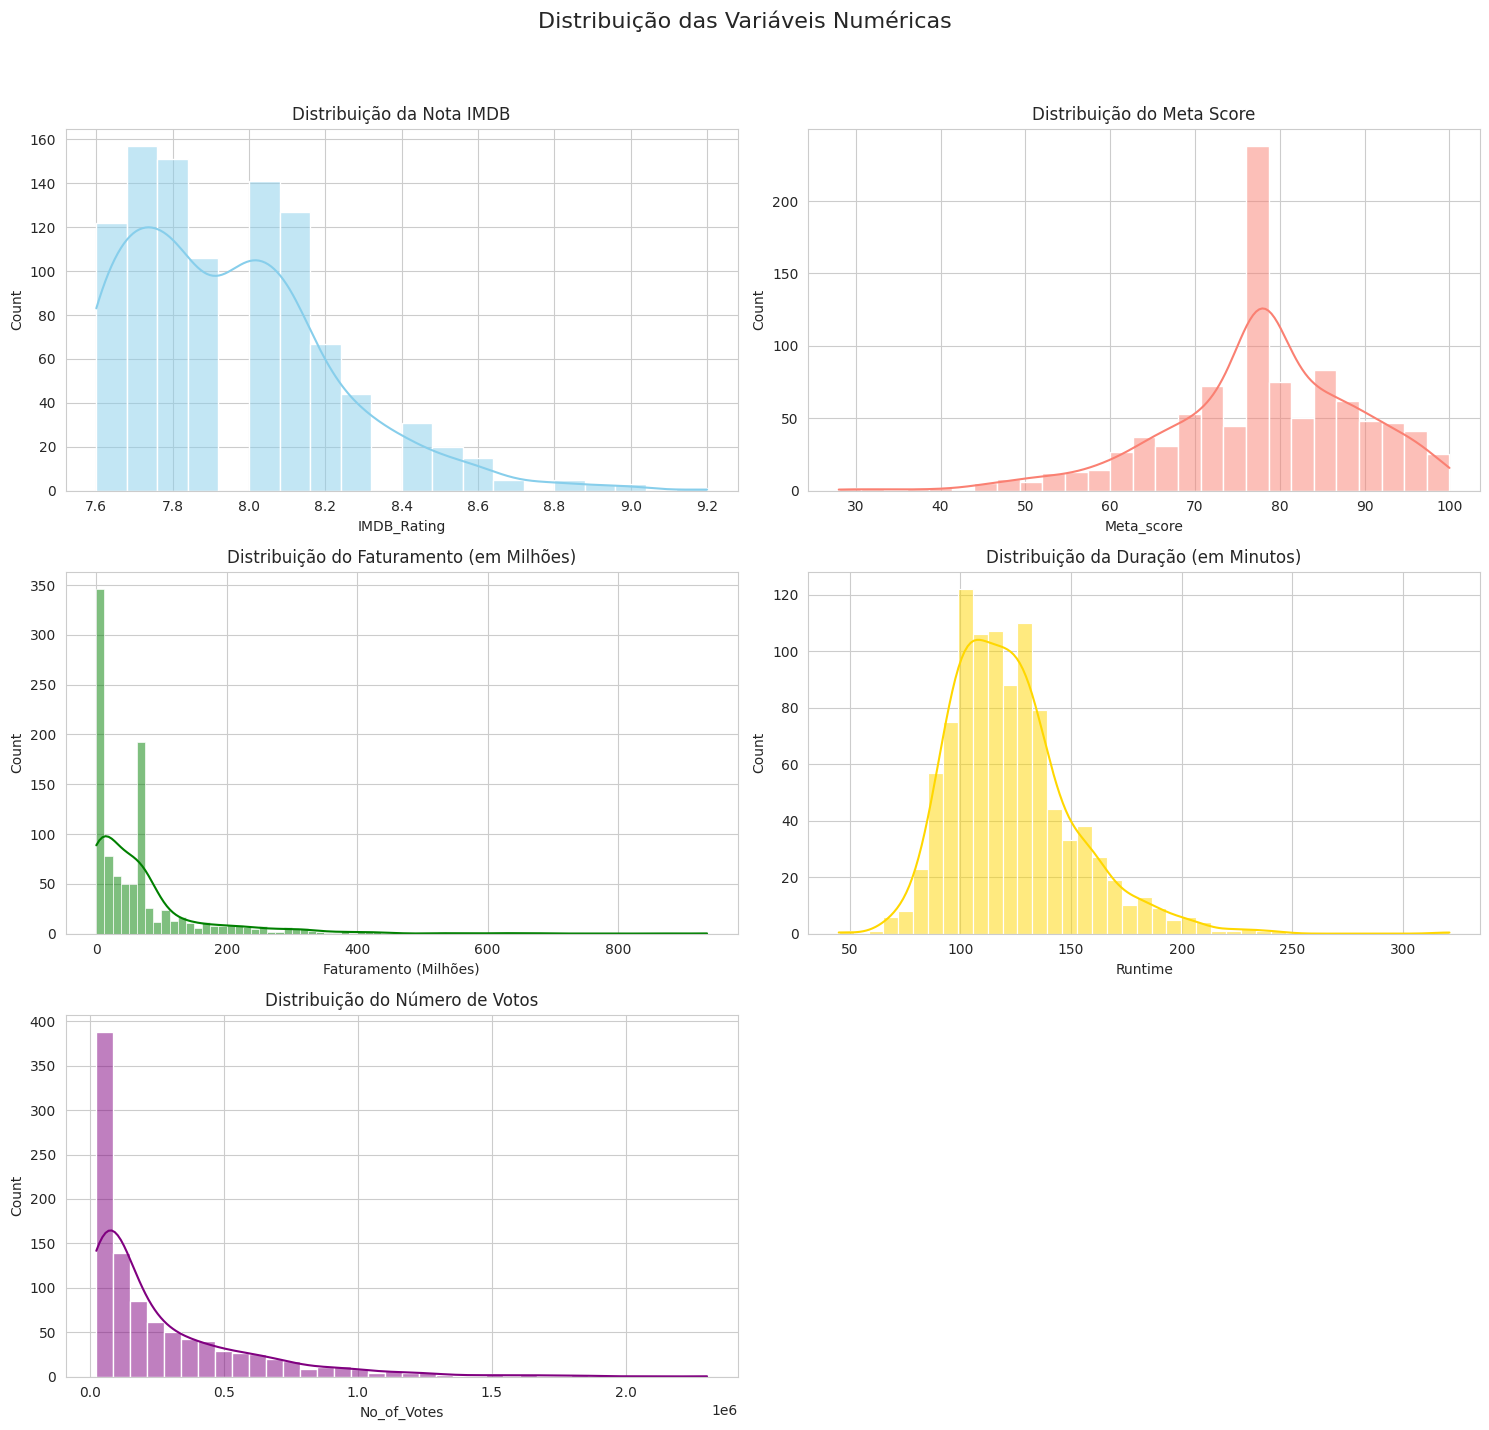

In [3]:
# Configurações de estilo para os gráficos
sns.set_style("whitegrid")

# Gráfico 1: Distribuição das Variáveis Numéricas
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Distribuição das Variáveis Numéricas', fontsize=16)

sns.histplot(df['IMDB_Rating'], kde=True, ax=axes[0, 0], color='skyblue').set_title('Distribuição da Nota IMDB')
sns.histplot(df['Meta_score'], kde=True, ax=axes[0, 1], color='salmon').set_title('Distribuição do Meta Score')
sns.histplot(df['Gross'] / 1e6, kde=True, ax=axes[1, 0], color='green').set(title='Distribuição do Faturamento (em Milhões)', xlabel='Faturamento (Milhões)')
sns.histplot(df['Runtime'], kde=True, ax=axes[1, 1], color='gold').set_title('Distribuição da Duração (em Minutos)')
sns.histplot(df['No_of_Votes'], kde=True, ax=axes[2, 0], color='purple').set_title('Distribuição do Número de Votos')
fig.delaxes(axes[2, 1]) # Remove o subplot vazio

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/tmp/ipython-input-1777152949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=genre_counts.index, x=genre_counts.values, orient='h', palette='viridis')


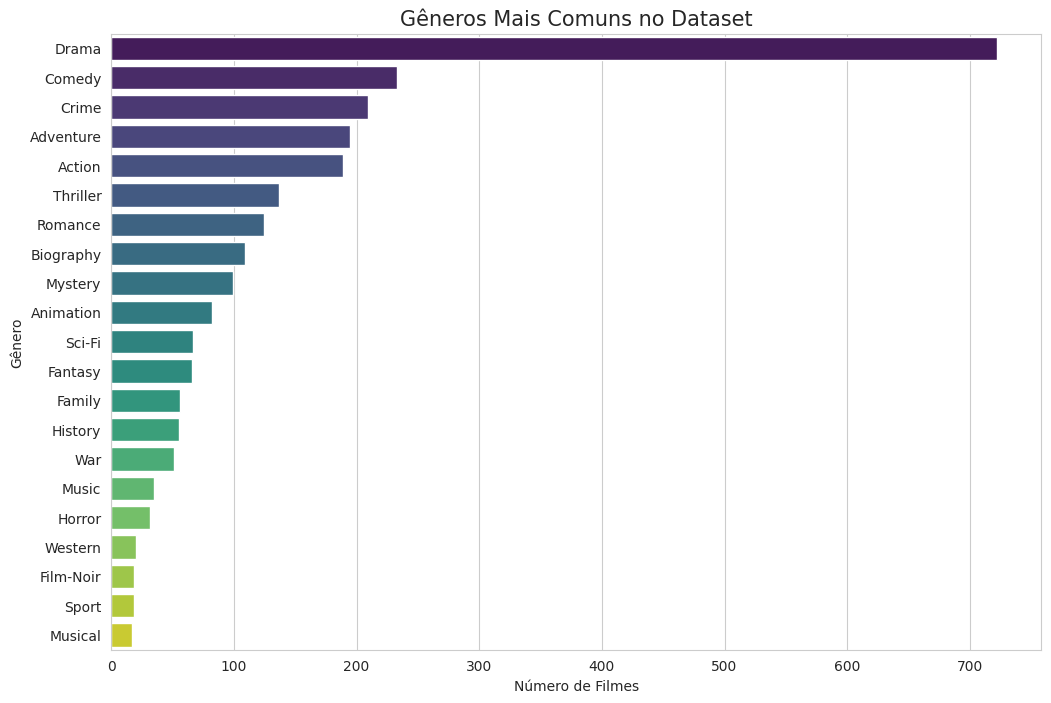

In [4]:
# Gráfico 2: Gêneros mais comuns
plt.figure(figsize=(12, 8))
# Separamos os gêneros que estão juntos na mesma linha (ex: "Action, Drama")
genre_counts = df['Genre'].str.split(', ').explode().value_counts()
sns.barplot(y=genre_counts.index, x=genre_counts.values, orient='h', palette='viridis')
plt.title('Gêneros Mais Comuns no Dataset', fontsize=15)
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.show()

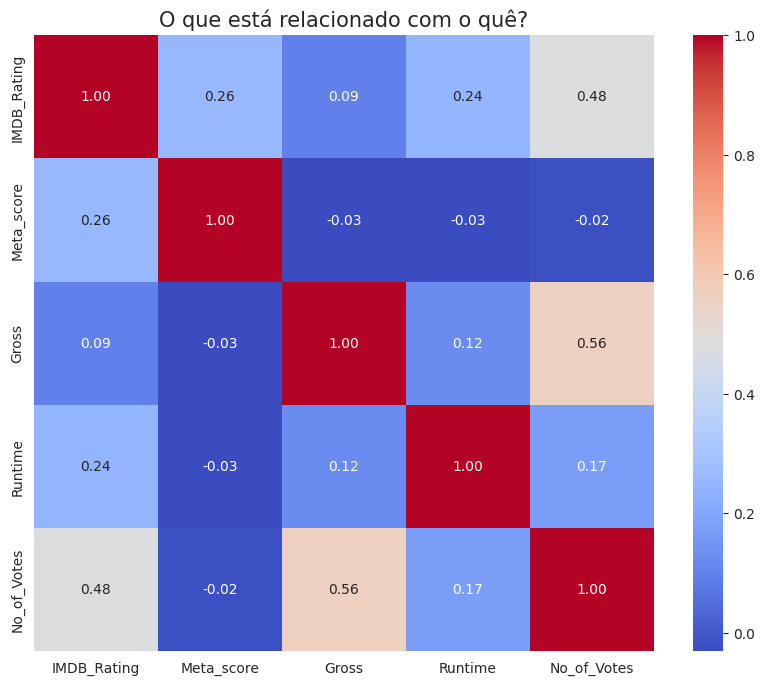

In [5]:
# Gráfico 3: Matriz de Correlação
plt.figure(figsize=(10, 8))
numerical_cols = ['IMDB_Rating', 'Meta_score', 'Gross', 'Runtime', 'No_of_Votes']
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('O que está relacionado com o quê?', fontsize=15)
plt.show()

**Insight da Correlação**: O fator mais correlacionado com o Faturamento (`Gross`) é o Número de Votos (`No_of_Votes`). Isso sugere que a popularidade e o engajamento do público são cruciais para o sucesso financeiro de um filme!

### Passo 3: O Vidente (Construindo um Modelo de Machine Learning)

Agora a parte mais legal! Vamos usar o que aprendemos para treinar um modelo de Machine Learning. O objetivo é que ele aprenda os padrões dos dados para conseguir **prever a nota IMDB** de um filme que ele nunca viu antes.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Definir as colunas que vamos usar para prever (features) e a coluna que queremos prever (target)
features = ['Meta_score', 'No_of_Votes', 'Gross', 'Runtime', 'Genre', 'Director', 'Star1']
target = 'IMDB_Rating'

X = df[features]
y = df[target]

# 2. Dividir os dados em um conjunto para treinar e outro para testar o modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Criar um "pipeline" de pré-processamento
# Isso vai transformar as colunas de texto (como Gênero e Diretor) em números que o modelo entende
categorical_features = ['Genre', 'Director', 'Star1']
numerical_features = ['Meta_score', 'No_of_Votes', 'Gross', 'Runtime']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# 4. Definir o modelo que vamos usar
# Random Forest é como um comitê de "árvores de decisão" que votam no resultado final
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 5. Juntar tudo em um Pipeline final
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

# 6. Treinar o modelo!
print("Treinando o modelo...")
pipeline.fit(X_train, y_train)
print("Modelo treinado com sucesso!")

Treinando o modelo...
Modelo treinado com sucesso!


### Passo 4: Testando o Vidente

In [7]:
# Avaliando o modelo com os dados de teste
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"O erro médio do nosso modelo é de: {rmse:.4f} pontos na nota IMDB.")

# Fazendo uma previsão para um filme específico
new_movie_data = {
    'Meta_score': 80.0,
    'No_of_Votes': 2343110,
    'Gross': 28341469.0,
    'Runtime': 142,
    'Genre': 'Drama',
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
}

new_movie_df = pd.DataFrame([new_movie_data])
predicted_rating = pipeline.predict(new_movie_df)

print(f"\nPrevisão para 'The Shawshank Redemption':")
print(f"Nota IMDB Prevista: {predicted_rating[0]:.2f}")

O erro médio do nosso modelo é de: 0.2088 pontos na nota IMDB.

Previsão para 'The Shawshank Redemption':
Nota IMDB Prevista: 8.77


### Passo 5: Empacotando o Modelo

Finalmente, salvamos nosso modelo treinado em um arquivo `.pkl`. Isso nos permite usar o modelo no futuro sem ter que treiná-lo de novo toda vez.

In [8]:
# Salvar o pipeline completo (pré-processador + modelo)
with open('imdb_rating_predictor.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("\nModelo salvo com sucesso no arquivo 'imdb_rating_predictor.pkl'")


Modelo salvo com sucesso no arquivo 'imdb_rating_predictor.pkl'
